## Import Necessary Libraries

In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

# Models
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


## Load the Dataset

In [62]:
df = pd.read_csv('../Data/for_ml_df.csv').drop("Unnamed: 0", axis=1)
df.head()

,Gender_F,Gender_M,Discipline_CNF,Discipline_CWT,Discipline_CWTB,Discipline_FIM,Card_RED,Card_WHITE,Card_YELLOW,Remarks_RED,...,Event Type_World Championship,Event Type_Worldrecord attempt,AP,RP,Depth_Difference,Points,Month,Year,Experience Dive,Experience Discipline
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,61.0,61.0,0.0,61.0,6.0,1994.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,72.0,72.0,0.0,72.0,9.0,1995.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,62.0,62.0,0.0,62.0,10.0,1996.0,1.0,1.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,72.0,72.0,0.0,72.0,10.0,1996.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,73.0,73.0,0.0,73.0,8.0,1997.0,0.0,0.0


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26700 entries, 0 to 26699
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender_F                        26700 non-null  float64
 1   Gender_M                        26700 non-null  float64
 2   Discipline_CNF                  26700 non-null  float64
 3   Discipline_CWT                  26700 non-null  float64
 4   Discipline_CWTB                 26700 non-null  float64
 5   Discipline_FIM                  26700 non-null  float64
 6   Card_RED                        26700 non-null  float64
 7   Card_WHITE                      26700 non-null  float64
 8   Card_YELLOW                     26700 non-null  float64
 9   Remarks_RED                     26700 non-null  float64
 10  Remarks_Syncope                 26700 non-null  float64
 11  Remarks_WHITE                   26700 non-null  float64
 12  Remarks_YELLOW                  

No null data which was expected, as it's our prepared for ml dataset.

In [64]:
df.columns

Index(['Gender_F', 'Gender_M', 'Discipline_CNF', 'Discipline_CWT',
       'Discipline_CWTB', 'Discipline_FIM', 'Card_RED', 'Card_WHITE',
       'Card_YELLOW', 'Remarks_RED', 'Remarks_Syncope', 'Remarks_WHITE',
       'Remarks_YELLOW', 'Event Type_Competition',
       'Event Type_Depth Competition', 'Event Type_Mixed Competition',
       'Event Type_Pool Competition', 'Event Type_Team Competition',
       'Event Type_World Championship', 'Event Type_Worldrecord attempt', 'AP',
       'RP', 'Depth_Difference', 'Points', 'Month', 'Year', 'Experience Dive',
       'Experience Discipline'],
      dtype='object')

# Machine Learning

## Heatmap

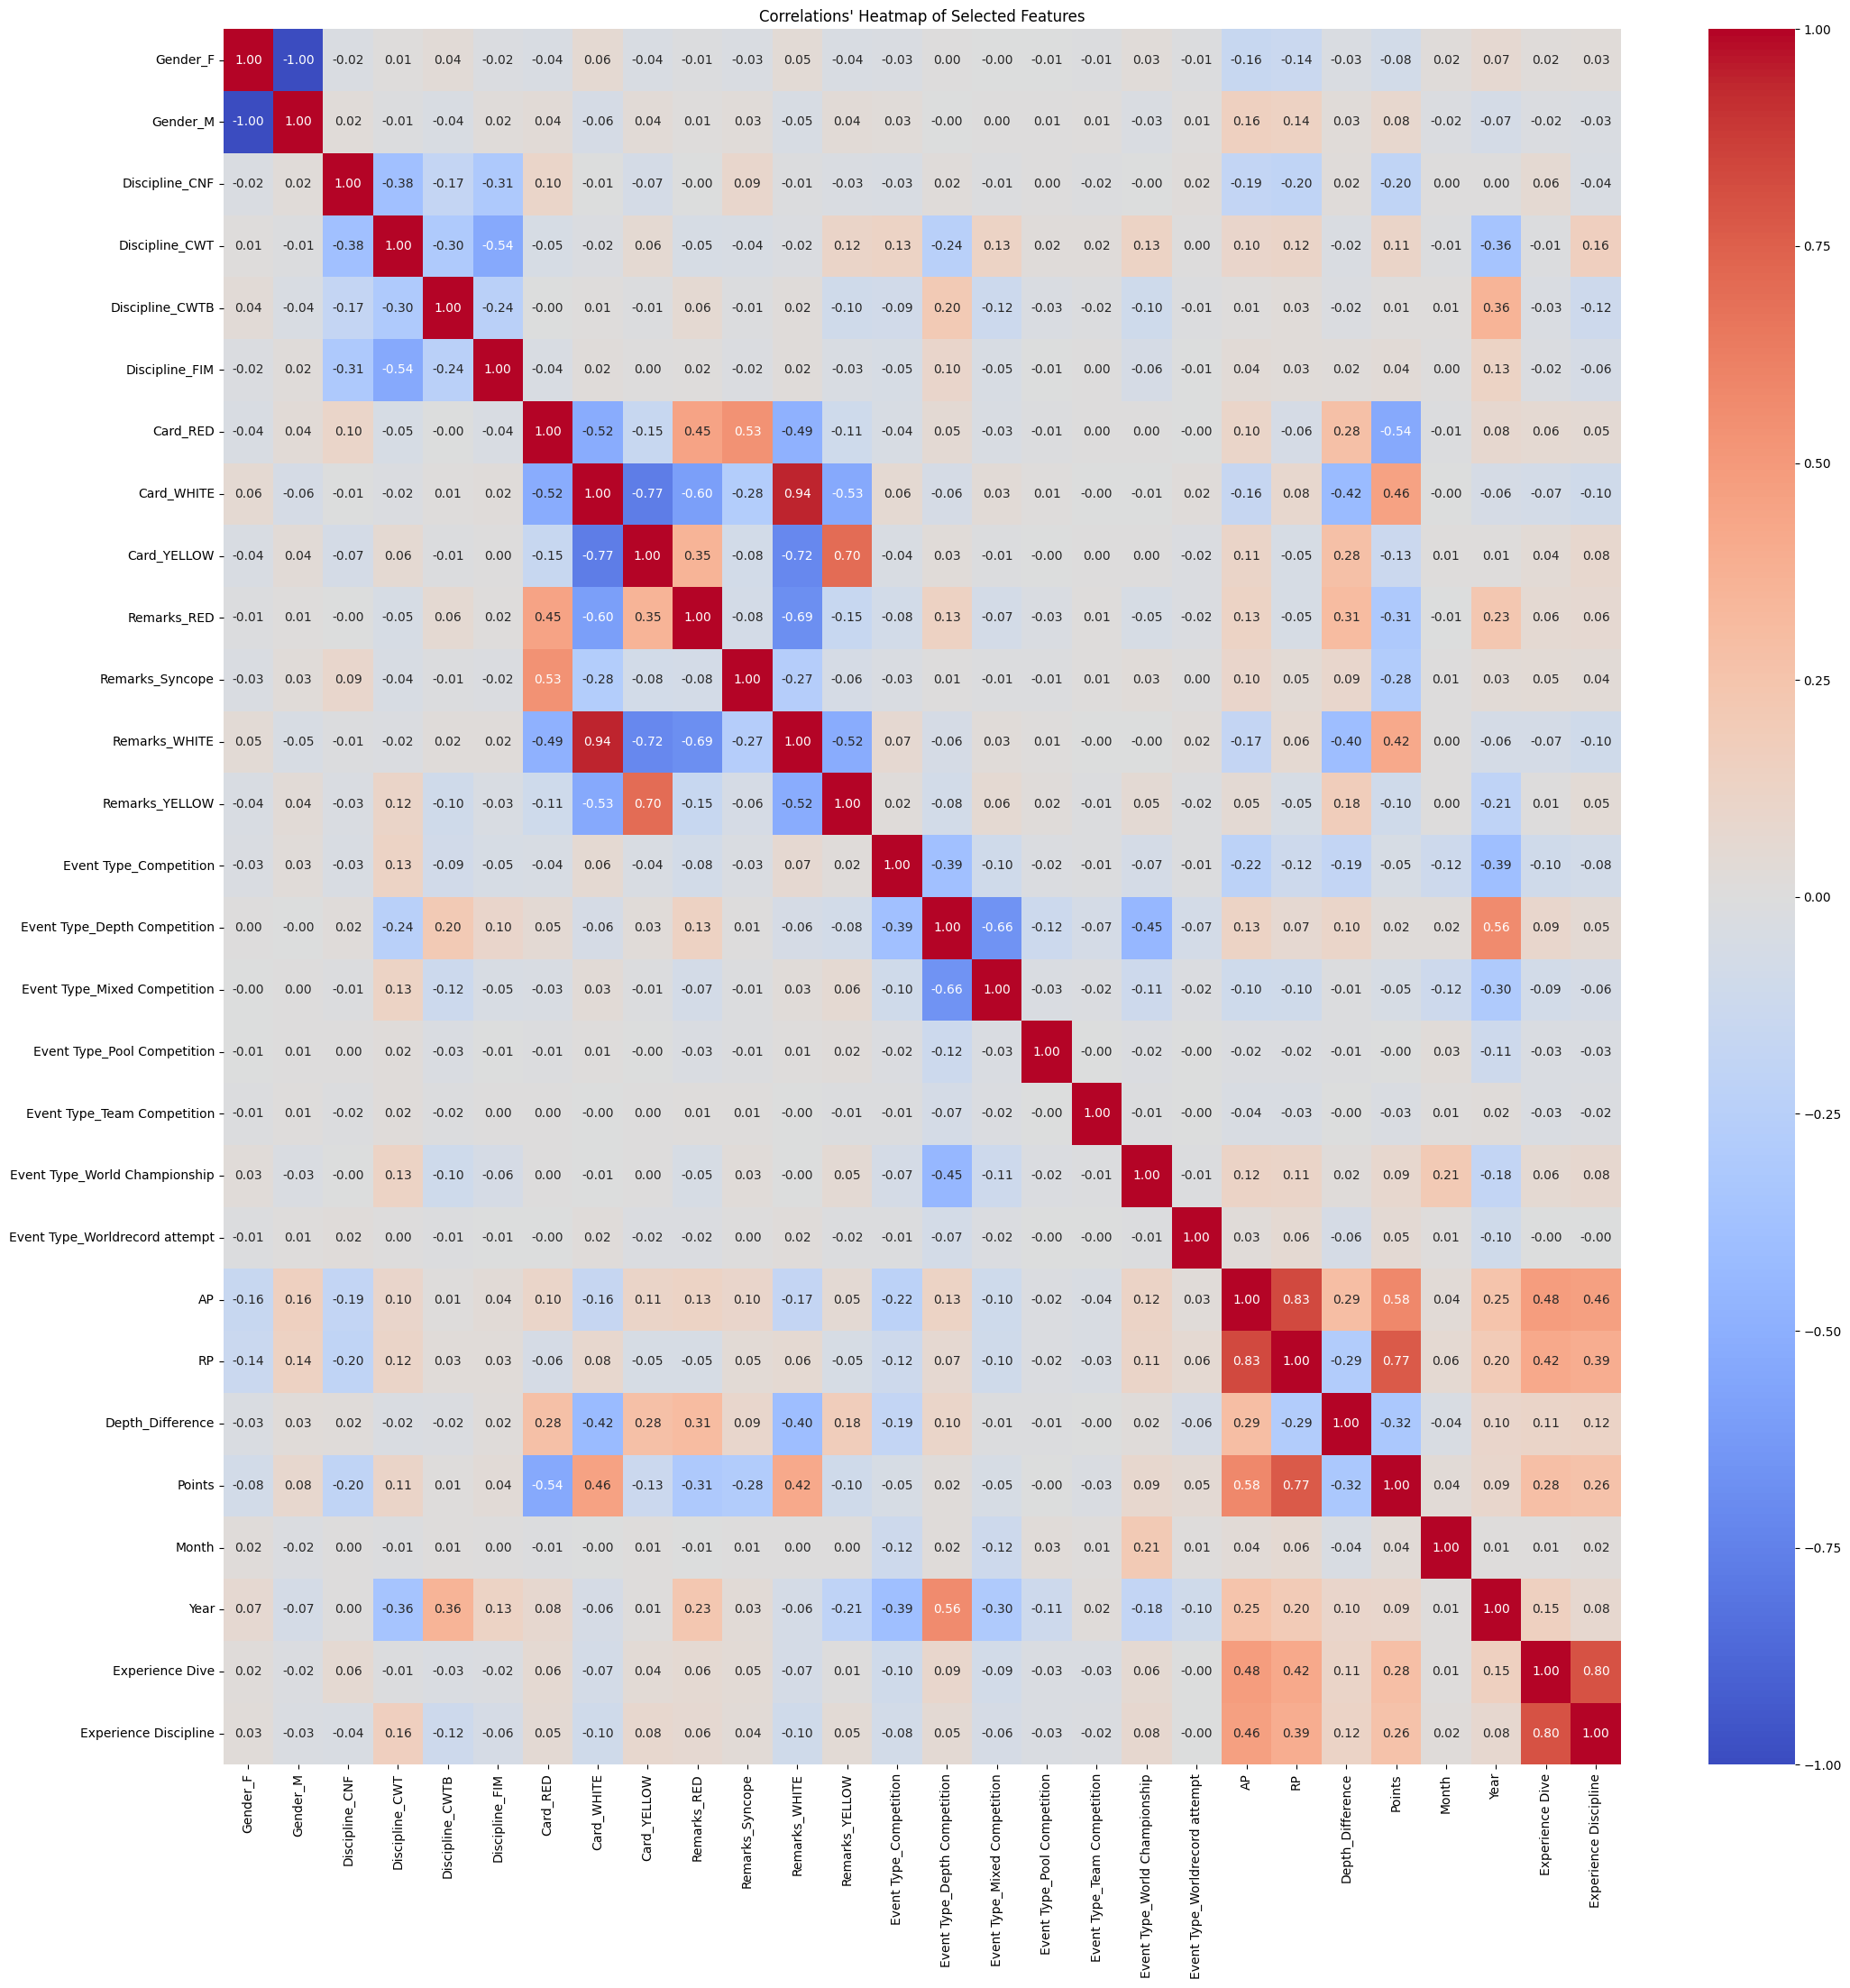

In [65]:
# Calculating the correlation matrix
correlation_matrix = df.corr()

# Plotting the heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlations' Heatmap of Selected Features")
plt.show()


Without going in details, we can't see interesting correlations between features that we didn't suspected to be correlated (like AP, RP and Points for example).

This makes our data suitable for clustering algorithms.

Here are more detailled analysis of the heatmap :

- Gender:

There are two gender categories, represented as Gender_F for female and Gender_M for male. They have a perfect negative correlation (-1) with each other, which is expected since they are mutually exclusive binary indicators.


- Discipline:

Several disciplines are listed (CNF, CMT, CMTB, FIN), and they show varying degrees of negative correlations with each other. This suggests that these are also mutually exclusive categories, which seems logical because they have different rules.


- Card Color: 

Card_RED and Card_WHITE are two categories that are also mutually exclusive, indicated by a perfect negative correlation of -1, which is totally expected.


- Academic Performance (AP): 

The feature AP has a moderately positive correlation with Experience_Dive (0.48) and Experience_Discipline (0.46), suggesting that divers tends to go deeper with more experience in diving or in a specific discipline, which make sense.


- Experience: 

The Experience_Dive and Experience_Discipline features have a very high positive correlation with each other (0.80), indicating that as experience in one increases, experience in the other tends to increase as well, which can mean that divers tends to stay in the same discpline.


- No Strong Correlations with Gender: 

Both Gender_F and Gender_M show very weak correlations with other features, suggesting that gender does not have a strong linear relationship with the other measured variables.


- Discipline Correlations: 

The discipline features show strong negative correlations with each other, especially Discipline_CMT and Discipline_FIN (-0.54), which suggests that they are distinct categories within the dataset.

- Experience and Card Color: 

There's a moderately negative correlation between Card_WHITE and both Experience_Dive and Experience_Discipline (-0.52 and -0.50, respectively). This could indicate that more experienced individuals are less likely to have a "white" card, which might represent that experienced divers tends to overestimate their skills, and got a yellow card because of that (with RP < AP).

## Clustering

In [35]:
df.columns

Index(['Gender_F', 'Gender_M', 'Discipline_CNF', 'Discipline_CWT',
       'Discipline_CWTB', 'Discipline_FIM', 'Card_RED', 'Card_WHITE',
       'Card_YELLOW', 'Remarks_RED', 'Remarks_Syncope', 'Remarks_WHITE',
       'Remarks_YELLOW', 'Event Type_Competition',
       'Event Type_Depth Competition', 'Event Type_Mixed Competition',
       'Event Type_Pool Competition', 'Event Type_Team Competition',
       'Event Type_World Championship', 'Event Type_Worldrecord attempt', 'AP',
       'RP', 'Depth_Difference', 'Points', 'Month', 'Year', 'Experience Dive',
       'Experience Discipline'],
      dtype='object')

In [36]:
selected_features = [
    'Discipline_CNF',
    'Discipline_CWT',
    'Discipline_CWTB',
    'Discipline_FIM',
    'AP',
    'Month',
    'Year',
    'Experience Dive',
    'Experience Discipline'
]

#### 1. KMeans

In [37]:
# Function to perform K-means clustering and plot Elbow curve
def kmeans_clustering_and_elbow_plot(data, features):
    # Scaling the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[features])

    # Calculating WCSS (Within-Cluster Sum of Square)
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', n_init='auto', random_state=42)
        kmeans.fit(scaled_data)
        wcss.append(kmeans.inertia_)

    # Plotting the Elbow Method graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    return wcss

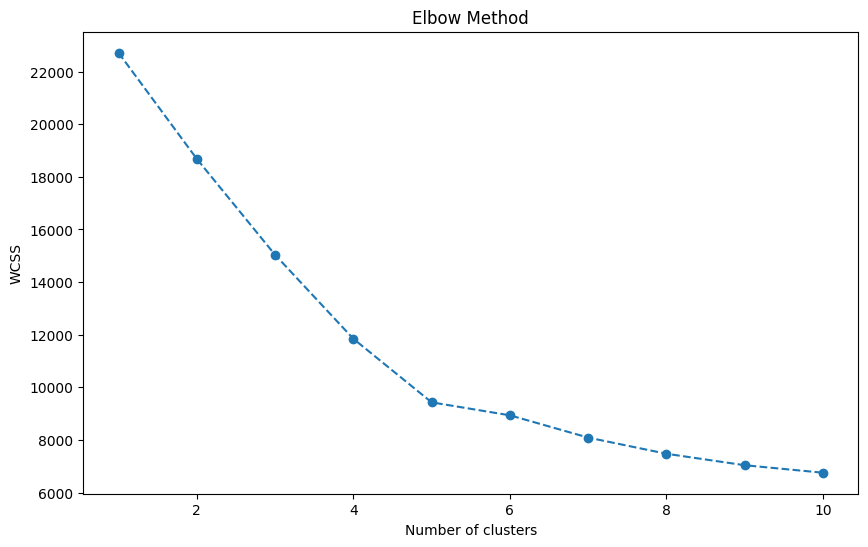

In [38]:
# Clustering for dives with RED card
wcss_red = kmeans_clustering_and_elbow_plot(df[df['Card_RED'] == 1], selected_features)

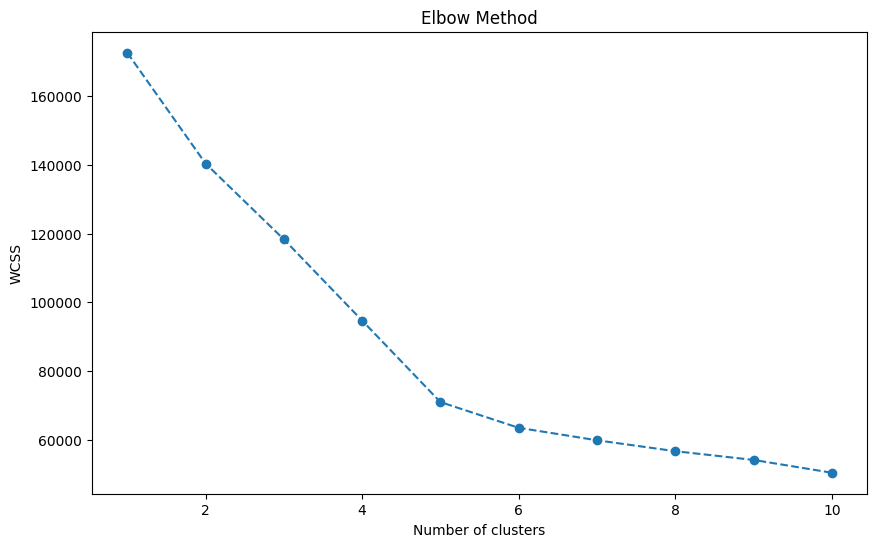

In [39]:
# Clustering for dives with WHITE card
wcss_white = kmeans_clustering_and_elbow_plot(df[df['Card_WHITE'] == 1], selected_features)

In [40]:
# Filtering data for Red Card and White Card
red_card_data = df[df['Card_RED'] == 1][selected_features]
white_card_data = df[df['Card_WHITE'] == 1][selected_features]

# Performing KMeans clustering with k = 5
kmeans_red = KMeans(n_clusters=5, n_init='auto', random_state=42).fit(red_card_data)
kmeans_white = KMeans(n_clusters=5, n_init='auto', random_state=42).fit(white_card_data)

# Adding cluster labels to the dataframes
red_card_data['Cluster'] = kmeans_red.labels_
white_card_data['Cluster'] = kmeans_white.labels_

# Displaying a summary of the clusters for each group
red_clusters_summary = red_card_data['Cluster'].value_counts()
white_clusters_summary = white_card_data['Cluster'].value_counts()

print(red_clusters_summary, white_clusters_summary)


Cluster
1    903
3    617
4    594
0    312
2     98
Name: count, dtype: int64 Cluster
3    7101
0    6532
4    3126
2    1446
1     981
Name: count, dtype: int64


Plongées avec un carton Rouge (Red Card):

Cluster 0: 312 plongées |
Cluster 1: 903 plongées |
Cluster 2: 98 plongées |
Cluster 3: 617 plongées |
Cluster 4: 594 plongées |

Plongées avec un carton Blanc (White Card):

Cluster 0: 6532 plongées | 
Cluster 1: 981 plongées |
Cluster 2: 1446 plongées |
Cluster 3: 7101 plongées |
Cluster 4: 3126 plongées |

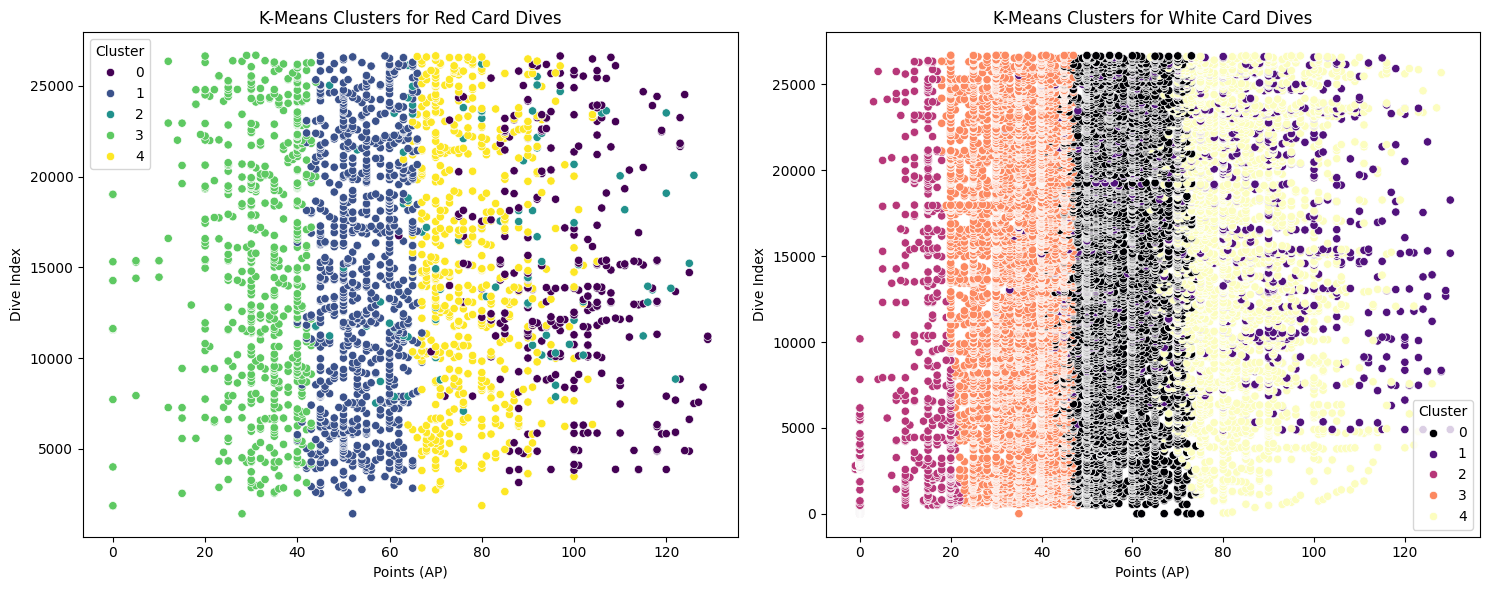

In [41]:
# Plotting the clusters for Red Card and White Card data
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot for Red Card data
sns.scatterplot(ax=axes[0], x=red_card_data['AP'], y=red_card_data.index, 
                hue=red_card_data['Cluster'], palette='viridis', legend='full')
axes[0].set_title('K-Means Clusters for Red Card Dives')
axes[0].set_xlabel('Points (AP)')
axes[0].set_ylabel('Dive Index')

# Plot for White Card data
sns.scatterplot(ax=axes[1], x=white_card_data['AP'], y=white_card_data.index, 
                hue=white_card_data['Cluster'], palette='magma', legend='full')
axes[1].set_title('K-Means Clusters for White Card Dives')
axes[1].set_xlabel('Points (AP)')
axes[1].set_ylabel('Dive Index')

plt.tight_layout()
plt.show()


Segmentation claire : J'ai pu identifier des segments distincts au sein des plongées, ce qui pourrait aider à comprendre des groupes spécifiques ou des comportements au sein de ces plongées.

Simplicité et efficacité : La méthode K-means est simple à comprendre et à mettre en œuvre. Elle est également efficace en termes de calcul, ce qui la rend adaptée à des ensembles de données de grande taille comme le vôtre.

Identification des tendances : Cette méthode m'a permis d'observer des tendances et des patterns au sein des données, en particulier en ce qui concerne la relation entre les disciplines de plongée, les points obtenus, et le type de carton reçu.

#### 2. DBSCAN

In [42]:
# Filtrage des données pour les plongées avec carton rouge et blanc
data_red = df[df['Card_RED'] == 1][selected_features]
data_white = df[df['Card_WHITE'] == 1][selected_features]

# Normalisation des données
scaler = StandardScaler()
data_red_scaled = scaler.fit_transform(data_red)
data_white_scaled = scaler.fit_transform(data_white)

# Afficher les dimensions des données filtrées et normalisées
data_red_scaled.shape, data_white_scaled.shape


((2524, 9), (19186, 9))

K-Distance Graph for Dives with Red Card:


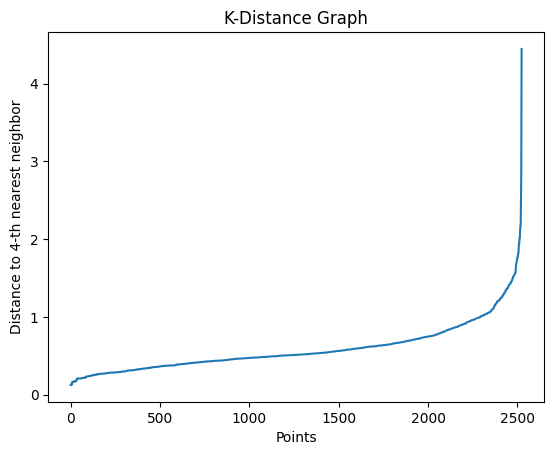

K-Distance Graph for Dives with White Card:


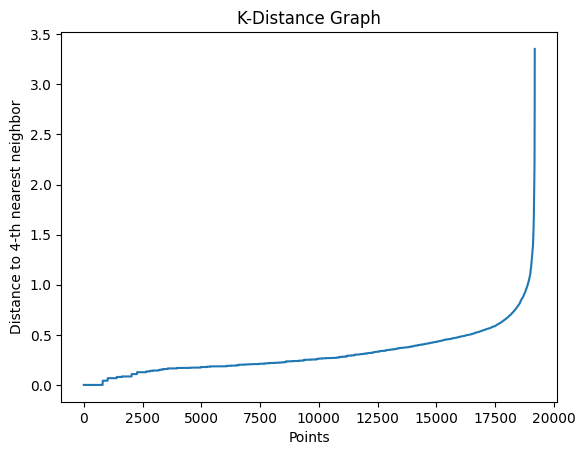

In [43]:
def plot_k_distance(data, k=4):
    """
    Plot the distance to the k-th nearest neighbor for each point in the dataset.
    This helps to determine a good value for 'eps' in DBSCAN.
    """
    # Calcul de la distance au k-ième voisin le plus proche pour chaque point
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(data)
    distances, indices = neighbors_fit.kneighbors(data)

    # Trier les distances
    sorted_distances = np.sort(distances[:, k-1], axis=0)

    # Tracer le graphique
    plt.plot(sorted_distances)
    plt.xlabel('Points')
    plt.ylabel('Distance to {}-th nearest neighbor'.format(k))
    plt.title('K-Distance Graph')
    plt.show()

# Tracer le graphique de la distance k-ème pour les plongées avec carton rouge
print("K-Distance Graph for Dives with Red Card:")
plot_k_distance(data_red_scaled)

# Tracer le graphique de la distance k-ème pour les plongées avec carton blanc
print("K-Distance Graph for Dives with White Card:")
plot_k_distance(data_white_scaled)


In [44]:
# Paramètres DBSCAN
eps_red = 1
eps_white = 0.05
min_samples = 5  # Un choix commun pour min_samples

# Application de DBSCAN aux plongées avec carton rouge
dbscan_red = DBSCAN(eps=eps_red, min_samples=min_samples)
clusters_red = dbscan_red.fit_predict(data_red_scaled)

# Application de DBSCAN aux plongées avec carton blanc
dbscan_white = DBSCAN(eps=eps_white, min_samples=min_samples)
clusters_white = dbscan_white.fit_predict(data_white_scaled)

# Calcul du nombre de clusters et de points de bruit pour chaque ensemble
n_clusters_red = len(set(clusters_red)) - (1 if -1 in clusters_red else 0)
n_noise_points_red = list(clusters_red).count(-1)

n_clusters_white = len(set(clusters_white)) - (1 if -1 in clusters_white else 0)
n_noise_points_white = list(clusters_white).count(-1)

(n_clusters_red, n_noise_points_red), (n_clusters_white, n_noise_points_white)


((5, 180), (78, 18373))

Pour les plongées avec un carton rouge :

Nombre de clusters formés : 5 |
Nombre de points considérés comme du bruit : 180 |

Pour les plongées avec un carton blanc :

Nombre de clusters formés : 78 |
Nombre de points considérés comme du bruit : 18373 |

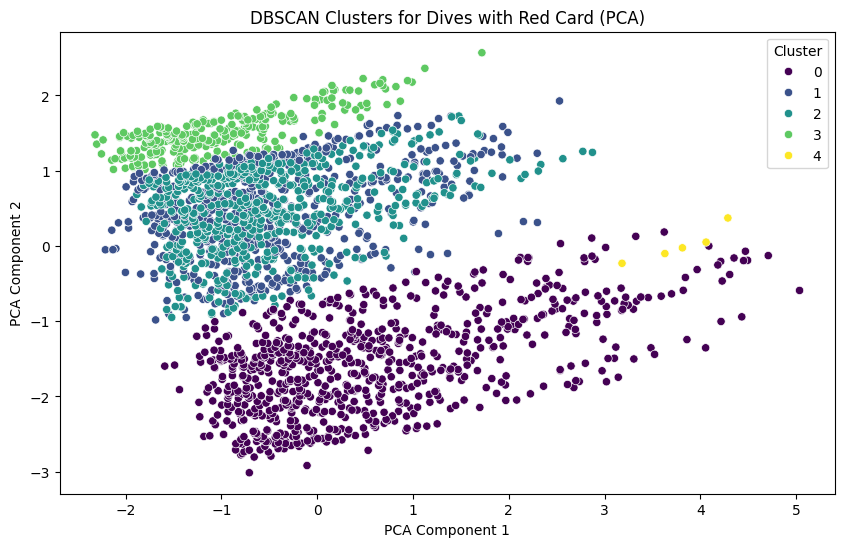

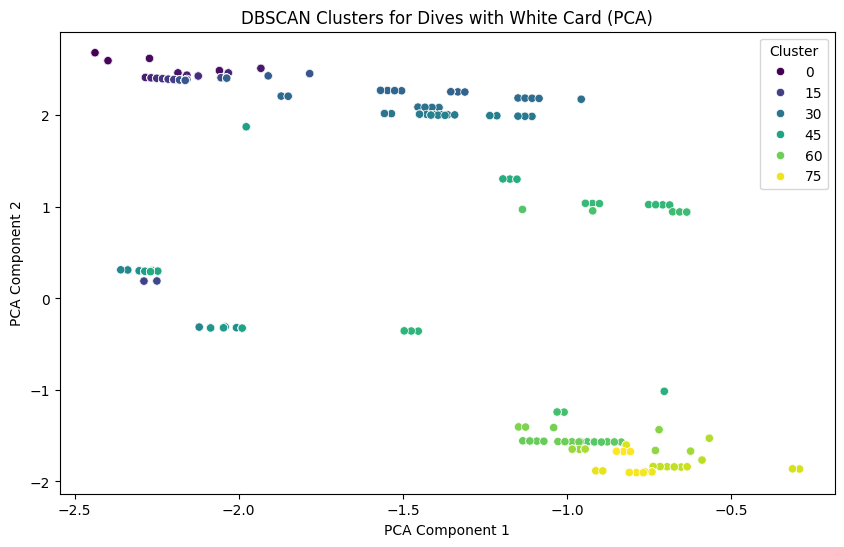

In [45]:
def apply_pca_and_plot_clusters(data, clusters, title):
    """
    Apply PCA to reduce data to two dimensions and plot the clusters.
    """
    # Réduction de dimensionnalité avec PCA
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data)

    # Création d'un DataFrame pour la visualisation
    plot_data = pd.DataFrame(data_pca, columns=['PCA1', 'PCA2'])
    plot_data['Cluster'] = clusters

    # Filtration pour enlever les points de bruit
    plot_data_filtered = plot_data[plot_data['Cluster'] != -1]

    # Tracé des clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=plot_data_filtered, x='PCA1', y='PCA2', hue='Cluster', palette='viridis')
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.show()

# Visualisation des clusters après réduction de dimensionnalité pour les plongées avec carton rouge
apply_pca_and_plot_clusters(data_red_scaled, clusters_red, "DBSCAN Clusters for Dives with Red Card (PCA)")

# Visualisation des clusters après réduction de dimensionnalité pour les plongées avec carton blanc
apply_pca_and_plot_clusters(data_white_scaled, clusters_white, "DBSCAN Clusters for Dives with White Card (PCA)")


Pour les plongées avec un carton rouge,on peut observer comment les plongées sont regroupées en différents clusters. Il semble y avoir une certaine séparation entre les groupes.

Pour les plongées avec un carton blanc, les clusters sont plus nombreux et plus dispersés, reflétant la variété dans les données de ces plongées.

# Classification


In [46]:
df.columns

Index(['Gender_F', 'Gender_M', 'Discipline_CNF', 'Discipline_CWT',
       'Discipline_CWTB', 'Discipline_FIM', 'Card_RED', 'Card_WHITE',
       'Card_YELLOW', 'Remarks_RED', 'Remarks_Syncope', 'Remarks_WHITE',
       'Remarks_YELLOW', 'Event Type_Competition',
       'Event Type_Depth Competition', 'Event Type_Mixed Competition',
       'Event Type_Pool Competition', 'Event Type_Team Competition',
       'Event Type_World Championship', 'Event Type_Worldrecord attempt', 'AP',
       'RP', 'Depth_Difference', 'Points', 'Month', 'Year', 'Experience Dive',
       'Experience Discipline'],
      dtype='object')

In [47]:
selected_features = [
    'Discipline_CNF',
    'Discipline_CWT',
    'Discipline_CWTB',
    'Discipline_FIM',
    'AP',
    'Month',
    'Year',
    'Experience Dive',
    'Experience Discipline'
]

#### SVM 

#### Justification des Choix
Choix des caractéristiques (features) : Les caractéristiques sélectionnées sont centrées sur les disciplines de la plongée et l'apnée (AP) et la performance réalisé (RP), ce qui semble pertinent pour prédire le type de carton reçu. Ces caractéristiques sont susceptibles d'avoir un impact direct sur la performance du plongeur et, par conséquent, sur le type de carton attribué.

Utilisation de SVM avec différents noyaux : SVM est un choix robuste pour la classification, capable de gérer à la fois des données linéaires et non linéaires. Les différents noyaux (linéaire, polynomial, RBF, sigmoid) permettent d'explorer diverses manières de séparer les données dans l'espace des caractéristiques. Le choix de tester différents noyaux est motivé par le désir de trouver la meilleure frontière de décision pour nos données spécifiques.

In [54]:
selected_features = [
    'Discipline_CNF',
    'Discipline_CWT',
    'Discipline_CWTB',
    'Discipline_FIM',
    'AP',
    'RP'
]

In [55]:
from sklearn.multiclass import OneVsRestClassifier

X = df[selected_features]
y = df[['Card_RED', 'Card_WHITE', 'Card_YELLOW']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
models = {}
for kernel in kernels:
    model = OneVsRestClassifier(SVC(kernel=kernel))
    model.fit(X_train, y_train)
    models[kernel] = model

# Évaluer les modèles
performance = {}
for kernel, model in models.items():
    y_pred = model.predict(X_test)
    performance[kernel] = classification_report(y_test, y_pred, output_dict=True)


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: Undefin

In [56]:
# Créer un DataFrame vide
performance_df = pd.DataFrame()

# Remplir le DataFrame avec les données du dictionnaire
for kernel, report in performance.items():
    for label, metrics in report.items():
        # Ignorer 'micro avg', 'macro avg', 'weighted avg', 'samples avg'
        if label in ['micro avg', 'macro avg', 'weighted avg', 'samples avg']:
            continue
        # Ajouter les données au DataFrame
        temp_df = pd.DataFrame.from_dict({(kernel, label): metrics}, orient='index')
        performance_df = pd.concat([performance_df, temp_df])

# Réorganiser l'index
performance_df.index.names = ['Kernel', 'Label']
performance_df.reset_index(inplace=True)

# Afficher le DataFrame
print(performance_df)


     Kernel Label  precision    recall  f1-score  support
0    linear     0   0.000000  0.000000  0.000000    507.0
1    linear     1   0.872677  0.992434  0.928711   3833.0
2    linear     2   0.456604  0.121000  0.191304   1000.0
3      poly     0   0.796296  0.084813  0.153298    507.0
4      poly     1   0.864368  0.994260  0.924776   3833.0
5      poly     2   0.917847  0.648000  0.759672   1000.0
6       rbf     0   0.766917  0.201183  0.318750    507.0
7       rbf     1   0.878928  0.992434  0.932239   3833.0
8       rbf     2   0.916459  0.735000  0.815760   1000.0
9   sigmoid     0   0.202156  0.147929  0.170843    507.0
10  sigmoid     1   0.733627  0.739369  0.736486   3833.0
11  sigmoid     2   0.237311  0.173000  0.200116   1000.0


Noyau Linéaire:

Classe 0: Les scores de précision, rappel et F1-score sont de 0, ce qui signifie que le modèle n'a pas pu identifier correctement les instances de la classe 0.
Classe 1: Des scores élevés en précision (0.87267) et rappel (0.992434), indiquant que le modèle est très performant pour identifier la classe 1.
Classe 2: Des performances médiocres avec une précision de 0.456604 et un rappel de 0.12100, indiquant que le modèle a du mal à détecter correctement la classe 2.

Noyau Polynomiale (poly):

Classe 0: De meilleures performances que le noyau linéaire avec une précision de 0.796296 et un rappel de 0.084813.
Classe 1: Des scores comparables au noyau linéaire avec une légère amélioration en précision.
Classe 2: De meilleures performances par rapport au noyau linéaire avec un rappel sensiblement amélioré (0.64800).

Noyau Radial Basis Function (rbf):

Classe 0: Des performances légèrement meilleures que le noyau linéaire avec une précision de 0.766917.
Classe 1: Des scores très similaires à ceux du noyau linéaire, indiquant une forte capacité à identifier correctement la classe 1.
Classe 2: Encore une fois, des performances meilleures que le noyau linéaire, avec une précision de 0.916459 et un rappel de 0.735000.

Noyau Sigmoidal (sigmoid):

Classe 0: Le modèle affiche une faible performance sur toutes les métriques.
Classe 1: Des performances acceptables avec une précision de 0.733627 et un rappel de 0.739369.
Classe 2: Des performances faibles avec une précision de 0.237311 et un rappel de 0.173000.

Support:

Le nombre de support indique le nombre d'occurrences réelles de chaque classe dans l'ensemble de test. La classe 0 a le moins de données, ce qui pourrait expliquer pourquoi tous les modèles ont du mal avec cette classe. Les classes 1 et 2 ont plus d'échantillons, et les modèles semblent mieux performer avec ces classes, en particulier avec la classe 1.

Conclusions:

Le noyau linéaire et le noyau RBF semblent être les plus performants, en particulier pour les classes 1 et 2.
Tous les noyaux ont du mal avec la classe 0, ce qui pourrait suggérer un besoin de techniques de rééquilibrage de la classe ou d'ingénierie de fonctionnalités supplémentaires pour mieux capturer les caractéristiques distinctives de cette classe.
Le noyau sigmoid a généralement montré les performances les plus faibles parmi les quatre types de noyaux.
Pour les classes avec peu d'échantillons (comme la classe 0), des techniques telles que le suréchantillonnage ou des méthodes de classification plus robustes aux déséquilibres de classe pourraient être explorées.

## Arbres de Décision

In [57]:
# Créer la colonne cible 'Card'
conditions = [
    df['Card_RED'] == 1.0,
    df['Card_WHITE'] == 1.0,
    df['Card_YELLOW'] == 1.0
]
choices = ['RED', 'WHITE', 'YELLOW']
df['Card'] = np.select(conditions, choices, default='UNKNOWN')

# Fractionner le DataFrame en ensembles de données d'entraînement et de test
X = df[selected_features]
y = df['Card']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Construire et entraîner le modèle de l'arbre de décision
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Prédire et évaluer le modèle
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

         RED       0.45      0.21      0.29       760
       WHITE       0.89      0.99      0.94      5749
      YELLOW       0.92      0.78      0.84      1501

    accuracy                           0.88      8010
   macro avg       0.75      0.66      0.69      8010
weighted avg       0.85      0.88      0.86      8010



Précision:

RED: Avec une précision de 0.45, le modèle ne prédit correctement la classe RED que 45% du temps. Cela signifie que plus de la moitié des prédictions de la classe RED sont incorrectes.
WHITE: La classe WHITE a une précision élevée de 0.89, ce qui signifie que le modèle prédit correctement la classe WHITE 89% du temps.
YELLOW: La précision est de 0.92 pour YELLOW, indiquant que les prédictions pour cette classe sont fiables.

Rappel (Sensibilité):

RED: Le rappel est très faible pour RED à 0.21, suggérant que le modèle manque de nombreuses instances réelles de cette classe.
WHITE: Un rappel de 0.99 pour WHITE est excellent, signifiant que le modèle identifie avec succès presque tous les cas réels de la classe WHITE.
YELLOW: Le rappel de 0.78 pour YELLOW est assez bon, indiquant que le modèle capture une grande proportion des cas réels de YELLOW.

F1-Score:

RED: Le F1-score pour RED est de 0.29, qui est assez bas, reflétant le mauvais équilibre entre la précision et le rappel pour cette classe.
WHITE: Avec un F1-score de 0.94, la classe WHITE montre une très bonne balance entre la précision et le rappel.
YELLOW: Un F1-score de 0.84 pour YELLOW est également considéré comme bon.

Support:

Les nombres de support indiquent le nombre d'instances réelles pour chaque classe dans l'ensemble de test. Il y a 760 instances de RED, 5749 de WHITE et 1501 de YELLOW. Ceci explique pourquoi le modèle peut être plus précis avec les classes WHITE et YELLOW - il y a plus de données pour apprendre de ces classes.

Moyennes Globales:

Accuracy: L'exactitude globale du modèle est de 0.88, ce qui est assez élevé.
Macro Avg: La moyenne macro de 0.75 pour la précision et 0.66 pour le rappel indique des performances moyennes lorsque toutes les classes sont considérées également.
Weighted Avg: La moyenne pondérée de la précision (0.85) et du rappel (0.88) est ajustée en fonction du support et montre de meilleures performances globales, reflétant l'influence des classes avec plus d'exemples (WHITE et YELLOW).

Conclusions :

Le modèle semble bien fonctionner pour les classes WHITE et YELLOW, mais il a du mal avec la classe RED. Cela peut être dû à moins d'exemples de formation pour la classe RED ou à un chevauchement des caractéristiques entre les classes.

# Bonus

In [69]:
# Preparing the feature matrix (X) and target vector (y)
X = df[selected_features]
y = df['Remarks_Syncope']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and fitting the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
report, conf_matrix


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: Undefin

('              precision    recall  f1-score   support\n\n         0.0       0.97      1.00      0.98      5179\n         1.0       0.00      0.00      0.00       161\n\n    accuracy                           0.97      5340\n   macro avg       0.48      0.50      0.49      5340\nweighted avg       0.94      0.97      0.96      5340\n',
 array([[5179,    0],
        [ 161,    0]], dtype=int64))

In [71]:
# Convertir la matrice de confusion en DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

# Convertir le rapport de classification en DataFrame
report_dict = classification_report(y_test, predictions, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Afficher les tableaux
print("Matrice de confusion:")
print(conf_matrix_df)
print("\nRapport de classification:")
print(report_df)


Matrice de confusion:
          Predicted 0  Predicted 1
Actual 0         5179            0
Actual 1          161            0

Rapport de classification:
              precision   recall  f1-score     support
0.0            0.969850  1.00000  0.984694  5179.00000
1.0            0.000000  0.00000  0.000000   161.00000
accuracy       0.969850  0.96985  0.969850     0.96985
macro avg      0.484925  0.50000  0.492347  5340.00000
weighted avg   0.940609  0.96985  0.955006  5340.00000


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: Undefin

Matrice de Confusion:

Vrais Négatifs (Actual 0, Predicted 0): 5179 - Le modèle a correctement prédit l'absence de syncope dans 5179 cas.
Faux Négatifs (Actual 1, Predicted 0): 161 - Le modèle a incorrectement prédit l'absence de syncope dans 161 cas où il y avait effectivement syncope.
Vrais Positifs (Actual 1, Predicted 1): 0 - Le modèle n'a correctement identifié aucun cas de syncope.
Faux Positifs (Actual 0, Predicted 1): 0 - Aucun cas de non-syncope n'a été incorrectement classé comme syncope.

Rapport de Classification:

Précision pour la classe 1 (Syncope): 0% - Le modèle ne peut pas correctement identifier les cas de syncope.
Rappel pour la classe 1 (Syncope): 0% - Le modèle n'a identifié correctement aucun des cas réels de syncope.
F1-Score pour la classe 1 (Syncope): 0% - Une moyenne harmonique faible de la précision et du rappel pour les cas de syncope.
Accuracy Globale: 97% - Bien que cela semble élevé, ce chiffre est trompeur car il est fortement influencé par le grand nombre de vrais négatifs.

Conclusion

Le modèle est biaisé vers la classe majoritaire (non-syncope). Ce déséquilibre de classe conduit à une faible performance pour la classe minoritaire (syncope). Des techniques comme le rééchantillonnage, l'utilisation de poids de classe, ou des méthodes de modélisation plus avancées pourraient être nécessaires pour améliorer la performance du modèle sur la classe minoritaire.